In [5]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import time
from numba import config
config.CUDA_ENABLE_PYNVJITLINK = 1


Image shape: (720, 720, 3)


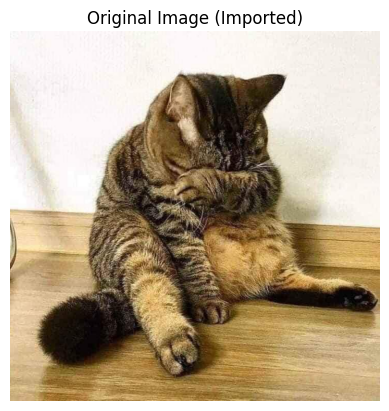

In [8]:
img = plt.imread("/content/drive/MyDrive/meme/15.jpg")
if img.dtype == np.uint8:
    img = img.astype(np.float32) / 255.0

h, w, c = img.shape
print("Image shape:", img.shape)

plt.imshow(img)
plt.title("Original Image (Imported)")
plt.axis("off")
plt.show()

In [10]:
h, w, c = img.shape
img_u8 = (img * 255).astype(np.uint8)   # scale về [0,255]
gray = np.zeros((h, w), dtype=np.uint8) # khởi tạo ảnh xám rỗng



In [16]:
@cuda.jit
def rgb2gray_2d(img, gray, width, height):
    x, y = cuda.grid(2)
    if x < width and y < height:
        idx = (y * width + x) * 3
        r = img[idx]
        g = img[idx + 1]
        b = img[idx + 2]
        gray[y, x] = (r + g + b) // 3

In [21]:
threadsperblock = (16, 16)
blockspergrid_x = (w + threadsperblock[0] - 1) // threadsperblock[0]
blockspergrid_y = (h + threadsperblock[1] - 1) // threadsperblock[1]
blockspergrid = (blockspergrid_x, blockspergrid_y)

print(f"Threads per block: {threadsperblock}")
print(f"Blocks per grid:   {blockspergrid}")


Threads per block: (16, 16)
Blocks per grid:   (45, 45)


In [22]:
flat_img = img_u8.reshape(-1)
d_img = cuda.to_device(flat_img)
d_gray = cuda.device_array((h, w), dtype=np.uint8)

In [23]:
t0 = time.time()
rgb2gray_2d[blockspergrid, threadsperblock](d_img, d_gray, w, h)
cuda.synchronize()
gpu_time = time.time() - t0
print(f"GPU (2D blocks) grayscale time: {gpu_time:.4f} seconds")

GPU (2D blocks) grayscale time: 0.0010 seconds


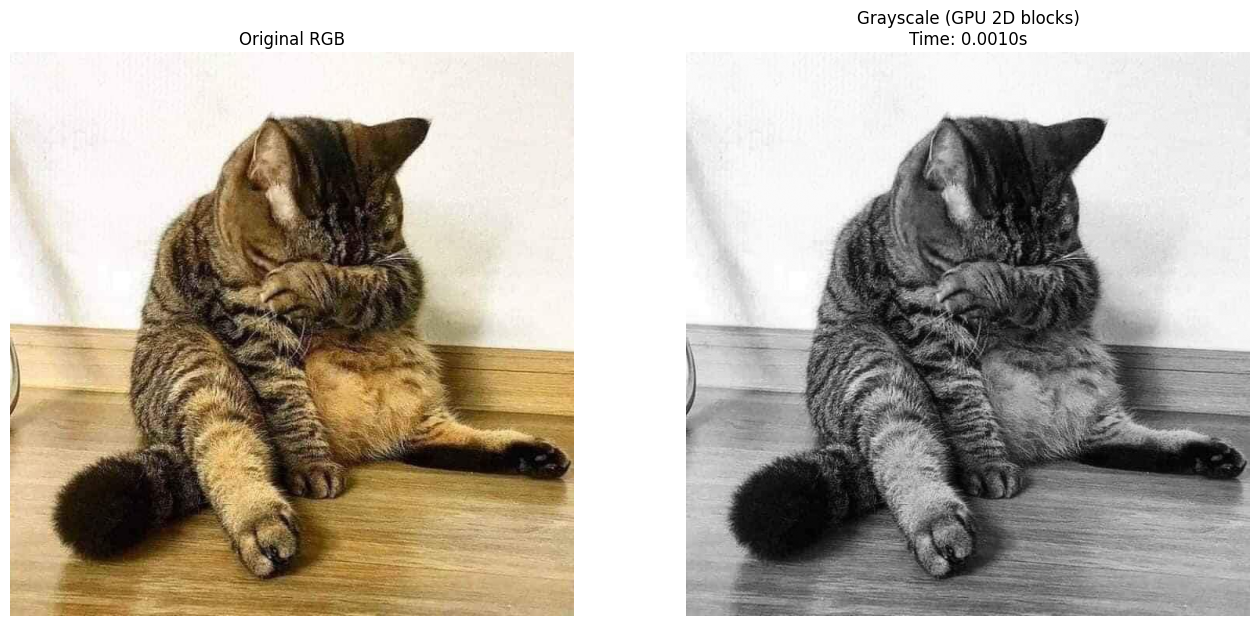

In [26]:
gray_gpu = d_gray.copy_to_host()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

ax1.imshow(img)
ax1.set_title("Original RGB")
ax1.axis("off")

ax2.imshow(gray_gpu, cmap="gray")
ax2.set_title(f"Grayscale (GPU 2D blocks)\nTime: {gpu_time:.4f}s")
ax2.axis("off")

plt.show()
